In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import json
import numpy as np
import proplot as pplt
from sklearn.metrics.pairwise import euclidean_distances

import warnings
warnings.filterwarnings("ignore")

COLORS = []
colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "../../mpcd_result/"
FIGURE_DIR = "../../mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.006, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [ ]:
from cg_topo_solv.analysis.result import load_target, load_all_fit
from matplotlib.ticker import NullLocator

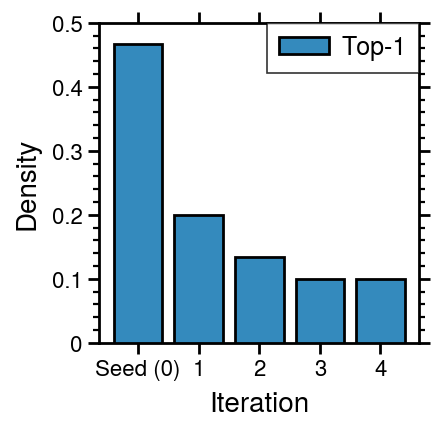

In [5]:
hi_idx, mid_idx, lo_idx, target_curves, target_labels, target_params = load_target(RESULT_DIR, verbose=False)
all_descriptors, all_params, all_curves, shear_rates, all_graphs    = load_all_fit(RESULT_DIR, rerun=False)

ref_curves = np.concatenate((all_curves[:30], all_curves[-150:]), axis=0)
mse_matrix = np.mean(np.square(ref_curves[None, :, :] - target_curves[:, None, :]), axis=2)

top1_idx   = np.argsort(mse_matrix, axis=1)[:, :1]
group1     = (top1_idx // 30).ravel()
ids1, cnt1 = np.unique(group1, return_counts=True)
ratio1     = cnt1 / cnt1.sum()

fig, ax = pplt.subplots(
    refwidth=1.6,
    refheight=1.6,
    ncols=1,
    nrows=1,
    sharey=False,
    sharex=False,
)

ax.bar(
    ids1,
    ratio1,
    facecolor=COLORS[0],
    edgecolor='k',
    lw=1,
    zorder=4,
    label="Top-1",
)

format_ax(ax)

ax.format(
    xlabel="Iteration",
    ylabel="Density",
    xticks=np.arange(6),
    xticklabels=["Seed (0)"] + [str(i) for i in range(1, 6)],
    ylim=(0.0, 0.5),
)

ax.legend(loc="upper right", ncol=1, prop={"size": 9})
ax.xaxis.set_minor_locator(NullLocator())

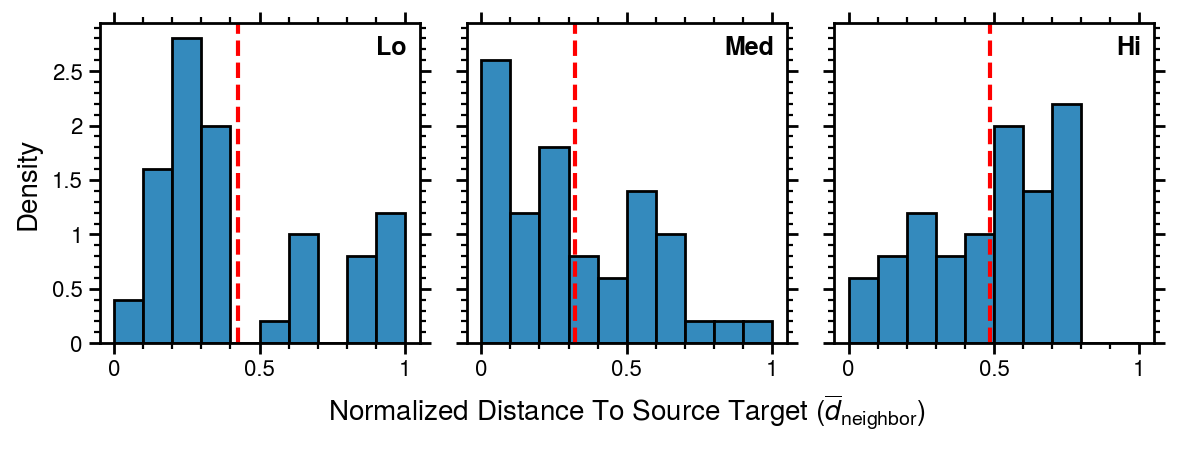

In [6]:
hi_idx, mid_idx, lo_idx, target_curves, target_labels, target_params = load_target(RESULT_DIR, verbose=False)
all_descriptors, all_params, all_curves, shear_rates, all_graphs    = load_all_fit(RESULT_DIR, rerun=False)

ref_curves = all_curves[-150:]
mse_base  = np.mean(np.square(ref_curves[None, :, :] - target_curves[:, None, :]), axis=2)
rank_idx  = np.argsort(mse_base, axis=1)
neighbor  = rank_idx % 30

params_log = np.copy(target_params)
params_log[:, 2] = np.log10(params_log[:, 2])

dist_mat = euclidean_distances(target_curves) / 100

rank_list = []
dist_list = []
for i in range(30):
    top = neighbor[i, :5]
    r = [np.argsort(dist_mat[i]).tolist().index(j) + 1 for j in top]
    d = [dist_mat[i, j] for j in top]
    rank_list.append(r)
    dist_list.append(d)

distances = np.array(dist_list)
norm_dist = distances / dist_mat.max(axis=1, keepdims=True)

fig, ax = pplt.subplots(ncols=3, refwidth=1.6, refheight=1.6)
texts    = ["Lo", "Med", "Hi"]
groups   = [lo_idx, mid_idx, hi_idx]

for i in range(3):
    vals = norm_dist[groups[i]].ravel()

    ax[i].hist(
        vals,
        bins=np.arange(-0.0, 1.01, 0.1),
        colors=COLORS[0],
        lw=1,
        edgecolor="k",
        density=True,
    )

    ax[i].axvline(vals.mean(), color='red', lw=1.5, linestyle='--')

    format_ax(ax[i])
    ax[i].text(0.96, 0.96, texts[i], ha='right', va='top', transform=ax[i].transAxes, size=9, weight='bold')
    ax[i].format(
        xlabel=r"Normalized Distance To Source Target ($\mathit{\overline{d}}_{neighbor}$)",
        ylabel="Density",
    )